In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
from data_utils import balanced_supersample, balanced_subsample
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import time
from collections import Counter

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [6]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )
df.head()

,target,h_target,metadata,fold
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...,3
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,2
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4


In [7]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,3
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,3
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,3
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,3
4,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,2


In [8]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,90.404900,91.055329,51.219845,80.379470,60.469820,53.184043,57.053467,52.325434,48.097754,33.733027,...,-0.233195,0.017153,11.873165,19.359034,4.525441,16.294592,5.168445,1,22,1
1,80.121191,72.052992,55.718821,72.454837,48.998552,51.988356,45.633356,51.398679,37.658179,34.016714,...,0.491172,0.096081,7.720529,16.587097,4.782730,11.854311,3.872817,1,22,1
2,76.894100,76.645729,51.827162,63.806498,46.999750,42.988174,33.721995,51.699638,41.009361,36.690496,...,-0.140477,-0.060608,8.262813,19.778991,3.826654,15.351905,2.801525,1,22,1
3,79.518072,67.946050,49.949992,57.617389,56.561281,49.811500,43.228721,41.536365,48.056511,39.072281,...,0.471951,-0.315736,8.975773,15.164488,4.304645,15.057390,3.335786,1,22,1
4,67.361420,53.421172,63.273243,61.723613,52.125176,46.464937,45.692597,40.873395,35.400075,30.040044,...,0.422322,0.366510,8.118086,15.510844,3.612748,13.472392,3.289428,1,22,1


In [9]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train[['h_target', 'target']]
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test[['h_target', 'target']]

In [10]:
print(train_X.shape)
print(test_X.shape)

(27732, 129)
(6990, 129)


In [11]:
%%file dnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

class DNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=35, validation_split=0.05,
                       a_epochs=50, a_batch_size=25,
                       i_epochs=50, i_batch_size=25,
                       verbose=1, proc=None
                ):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
        if self.proc:
            X = self.proc.fit_transform(X, y[:,1])
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=dims,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=dims,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=dims,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        if self.proc:
            X = self.proc.transform(np.array(X))
    
        for x in X:
            prob = self.clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze()
            if prob[0] > 0.75:
                pred = self.a_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
            elif prob[1] > 0.75:
                pred = self.i_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
            else:
                a_pred = self.a_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
                i_pred = self.i_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
                
                a_prob = self.a_clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        if self.proc:
            X = self.proc.transform(np.array(X))
        
#         print(self.a_clf.classes_)
#         print(self.i_clf.classes_)
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()
        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze().T,prob[:,0]).T
        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze().T,prob[:,1]).T

        probs = []
        
        for i in range(0, len(prob_a)):
            tmp = [None] * 50
            for counter, j in enumerate(self.a_clf.classes_):
                tmp[j] = prob_a[i][counter]
            for counter, j in enumerate(self.i_clf.classes_):
                tmp[j] = prob_i[i][counter]
            probs.append(tmp)
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='softmax'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'])


        return model

    def deep_net_a(self, feature_count):
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(18, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting dnnmult.py


## Training

In [12]:
from dnnmult import DNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

proc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50))
])

clf = DNN_Multilayer(proc=proc)

clf.fit(train_X, train_y)

Train on 26345 samples, validate on 1387 samples
Epoch 1/50
26345/26345 [==============================] - 3s 96us/step - loss: 5.6556 - acc: 0.6452 - val_loss: 6.4597 - val_acc: 0.5948
Epoch 2/50
26345/26345 [==============================] - 2s 85us/step - loss: 5.6556 - acc: 0.6452 - val_loss: 6.4597 - val_acc: 0.5948
Epoch 3/50
26345/26345 [==============================] - 2s 83us/step - loss: 5.6556 - acc: 0.6452 - val_loss: 6.4597 - val_acc: 0.5948
Epoch 4/50
26345/26345 [==============================] - 2s 82us/step - loss: 5.6556 - acc: 0.6452 - val_loss: 6.4597 - val_acc: 0.5948
Epoch 5/50
26345/26345 [==============================] - 2s 82us/step - loss: 5.6556 - acc: 0.6452 - val_loss: 6.4597 - val_acc: 0.5948
Epoch 6/50
26345/26345 [==============================] - 2s 83us/step - loss: 5.6556 - acc: 0.6452 - val_loss: 6.4597 - val_acc: 0.5948
Epoch 7/50
26345/26345 [==============================] - 2s 73us/step - loss: 5.6556 - acc: 0.6452 - val_loss: 6.4597 - val_acc:

Epoch 10/50
9412/9412 [==============================] - 1s 88us/step - loss: 1.3596 - acc: 0.5569 - val_loss: 2.2443 - val_acc: 0.3024
Epoch 11/50
9412/9412 [==============================] - 1s 95us/step - loss: 1.3080 - acc: 0.5704 - val_loss: 2.1929 - val_acc: 0.3488
Epoch 12/50
9412/9412 [==============================] - 1s 99us/step - loss: 1.2376 - acc: 0.5938 - val_loss: 2.3151 - val_acc: 0.3327
Epoch 13/50
9412/9412 [==============================] - 1s 95us/step - loss: 1.1767 - acc: 0.6168 - val_loss: 2.3818 - val_acc: 0.3367
Epoch 14/50
9412/9412 [==============================] - 1s 92us/step - loss: 1.1272 - acc: 0.6303 - val_loss: 2.3506 - val_acc: 0.3105
Epoch 15/50
9412/9412 [==============================] - 1s 95us/step - loss: 1.0867 - acc: 0.6427 - val_loss: 2.3415 - val_acc: 0.3508
Epoch 16/50
9412/9412 [==============================] - 1s 79us/step - loss: 1.0407 - acc: 0.6601 - val_loss: 2.6437 - val_acc: 0.3024
Epoch 17/50
9412/9412 [=========================

DNN_Multilayer(a_batch_size=25, a_epochs=50, batch_size=35, epochs=50,
        i_batch_size=25, i_epochs=50,
        proc=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7f2479682378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))]),
        validation_split=0.05, verbose=1)

0.25608011444921314
0.167996981343356
Confusion matrix, without normalization
[[ 0  0  0 ...  4 23  3]
 [ 0  0  0 ...  1  4  0]
 [ 0  0  0 ...  4 10 10]
 ...
 [ 0  0  0 ... 80  0  0]
 [ 0  0  0 ...  0 92  0]
 [ 0  0  0 ...  0  0 92]]


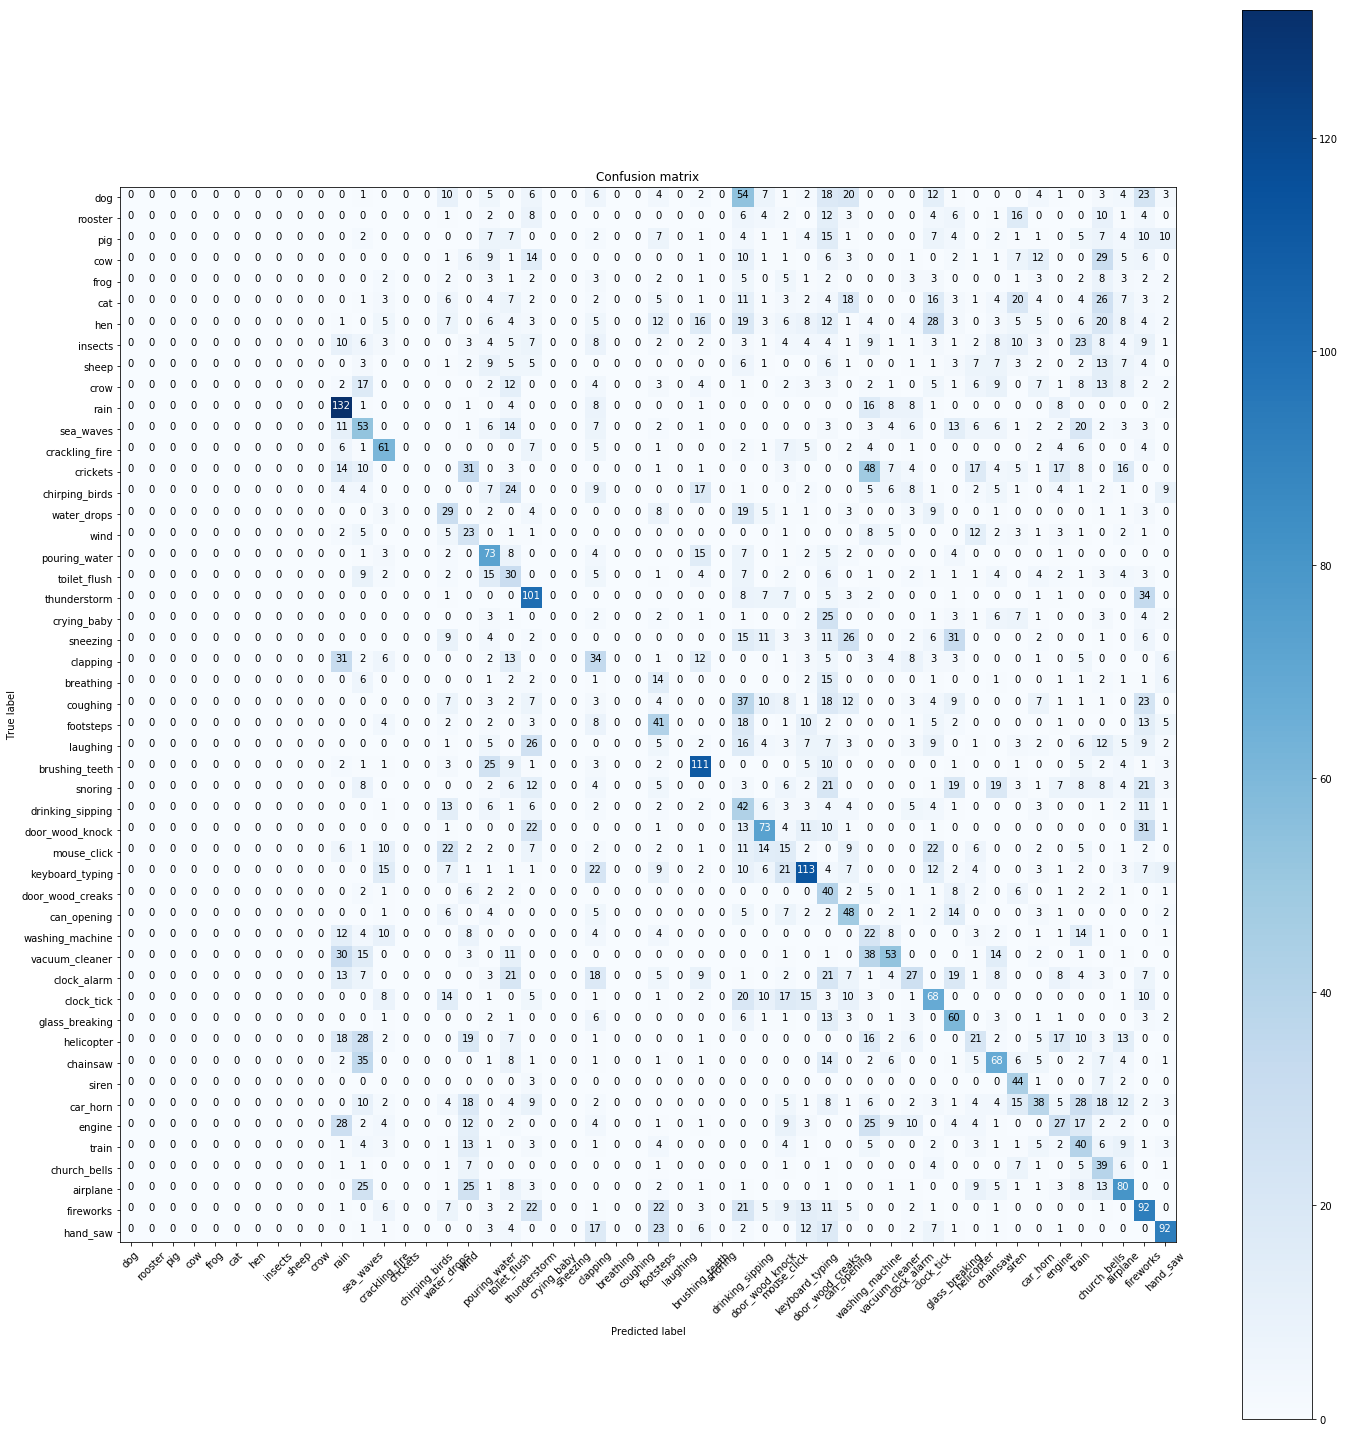

In [33]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y.values[:,1], pred))
print(metrics.precision_score(test_y.values[:,1], pred, average='macro'))
cm = metrics.confusion_matrix(test_y.values[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [14]:
t_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False
                       )
t_df.head()

,target,h_target,metadata
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...


In [15]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

test = df[df.fold == 1]

for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.04746413230895996
	File Time: 0.03760361671447754
	File Time: 0.03390789031982422
	File Time: 0.02838897705078125
	File Time: 0.02759242057800293
	File Time: 0.028071880340576172
	File Time: 0.04584693908691406
	File Time: 0.03789949417114258
	File Time: 0.03148984909057617
	File Time: 0.0420076847076416
	File Time: 0.015741348266601562
	File Time: 0.0468442440032959
	File Time: 0.03987431526184082
	File Time: 0.03625226020812988
	File Time: 0.044905662536621094
	File Time: 0.039885520935058594
	File Time: 0.04261589050292969
	File Time: 0.04610300064086914
	File Time: 0.024933338165283203
	File Time: 0.04342007637023926
	File Time: 0.041587114334106445
	File Time: 0.04481959342956543
	File Time: 0.04482841491699219
	File Time: 0.051197052001953125
	File Time: 0.04587125778198242
	File Time: 0.0399625301361084
	File Time: 0.03586530685424805
	File Time: 0.03301191329956055
	File Time: 0.04281902313232422
	File Time: 0.03081345558166504
	File Time: 0.032071828842163086
	Fi

	File Time: 0.030319690704345703
	File Time: 0.04417681694030762
	File Time: 0.031172752380371094
	File Time: 0.02323627471923828
	File Time: 0.020401477813720703
	File Time: 0.028343677520751953
	File Time: 0.0285489559173584
	File Time: 0.029305219650268555
	File Time: 0.04112076759338379
	File Time: 0.04610919952392578
	File Time: 0.043630123138427734
	File Time: 0.04330635070800781
	File Time: 0.04321575164794922
	File Time: 0.04751396179199219
	File Time: 0.051520586013793945
	File Time: 0.04278969764709473
	File Time: 0.036757707595825195
	File Time: 0.03421735763549805
	File Time: 0.03835916519165039
	File Time: 0.023668527603149414
	File Time: 0.04172992706298828
	File Time: 0.047797441482543945
	File Time: 0.0458984375
	File Time: 0.048271894454956055
	File Time: 0.050252437591552734
	File Time: 0.05137014389038086
	File Time: 0.04194808006286621
	File Time: 0.036264657974243164
	File Time: 0.03327488899230957
	File Time: 0.03087902069091797
	File Time: 0.03018045425415039
	Fi

0.3625
0.2496936892943085
Confusion matrix, without normalization
[[ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  1  0  1]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  8]]


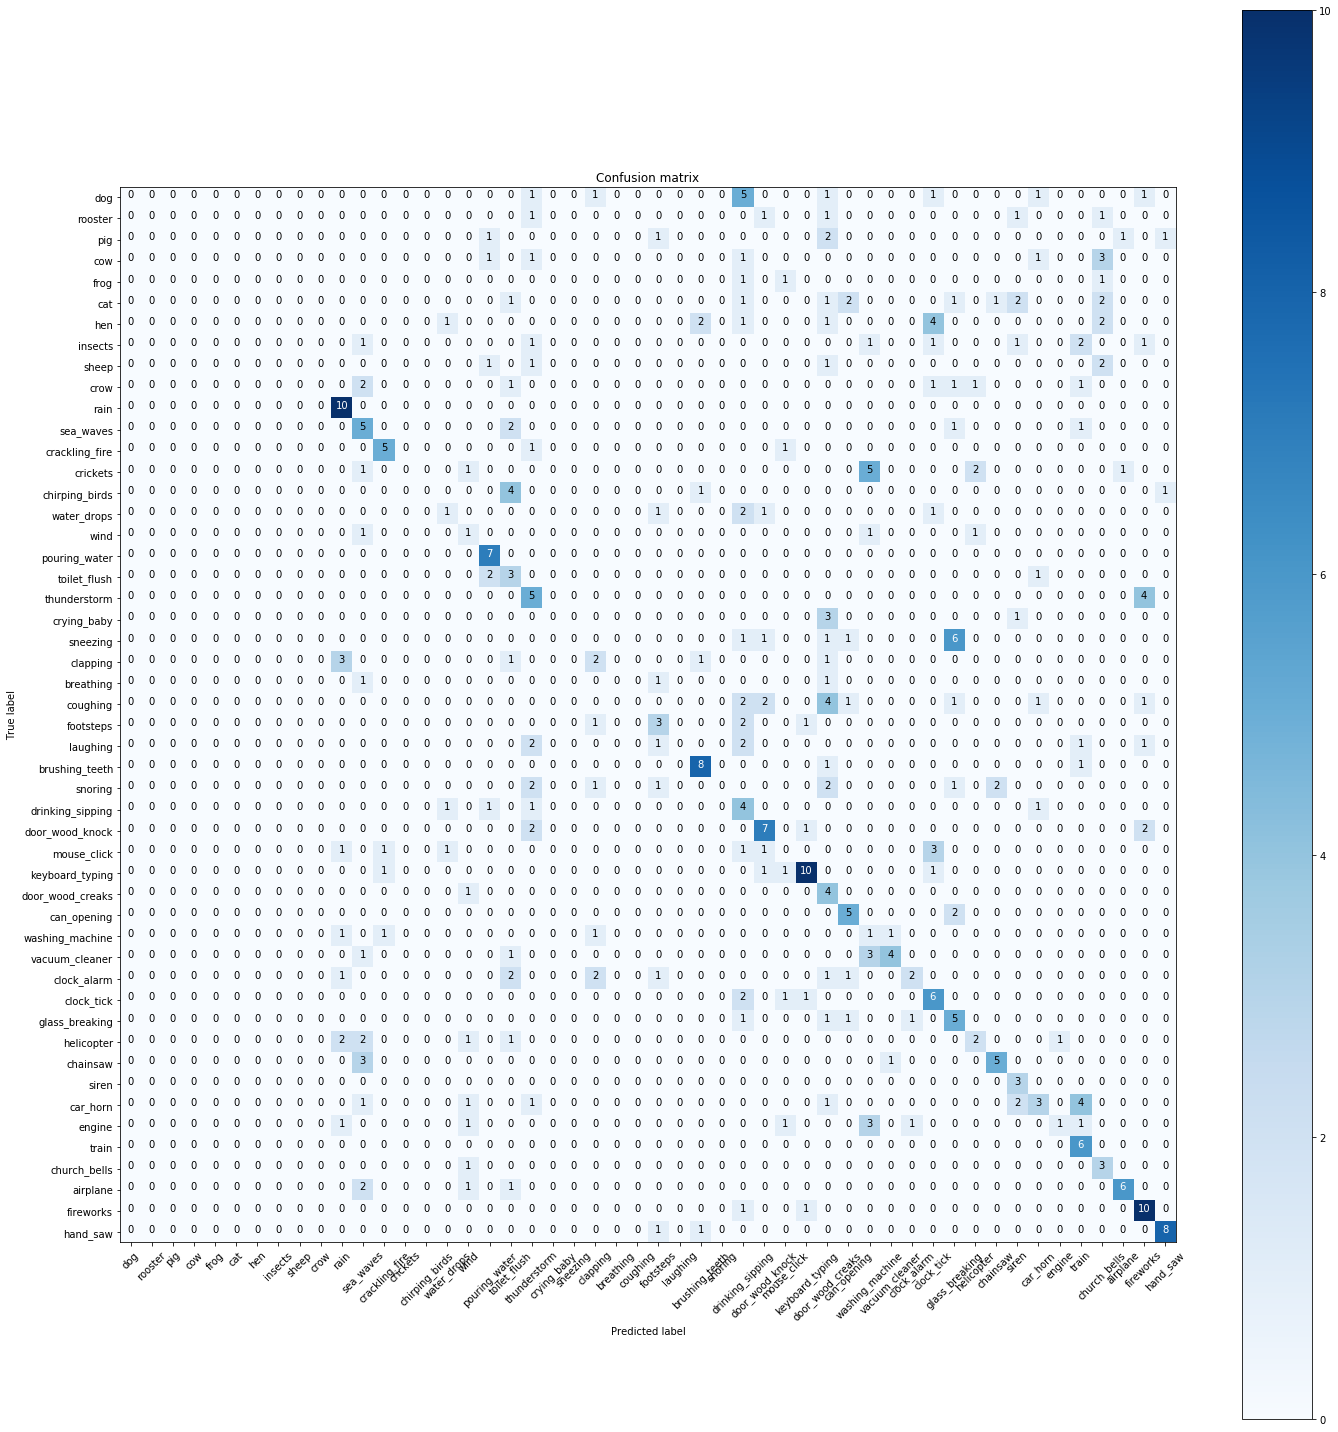

In [32]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [34]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

for data_iloc in range(0,len(df)):
    s_time = time.time()
    x_file = df.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

    y_file = df.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.02411651611328125
	File Time: 0.055451154708862305
	File Time: 0.05350685119628906
	File Time: 0.049736976623535156
	File Time: 0.05071830749511719
	File Time: 0.04992246627807617
	File Time: 0.03905129432678223
	File Time: 0.04473161697387695
	File Time: 0.048478126525878906
	File Time: 0.017148971557617188
	File Time: 0.017973661422729492
	File Time: 0.048212528228759766
	File Time: 0.04435086250305176
	File Time: 0.0415194034576416
	File Time: 0.011312484741210938
	File Time: 0.04794907569885254
	File Time: 0.0477290153503418
	File Time: 0.04778695106506348
	File Time: 0.052336931228637695
	File Time: 0.04893779754638672
	File Time: 0.043344974517822266
	File Time: 0.037978410720825195
	File Time: 0.0438382625579834
	File Time: 0.05000925064086914
	File Time: 0.043059349060058594
	File Time: 0.04104733467102051
	File Time: 0.0393519401550293
	File Time: 0.04351067543029785
	File Time: 0.039496660232543945
	File Time: 0.03775286674499512
	File Time: 0.043740034103393555

	File Time: 0.030159473419189453
	File Time: 0.030327796936035156
	File Time: 0.030084609985351562
	File Time: 0.014195919036865234
	File Time: 0.02938103675842285
	File Time: 0.05193352699279785
	File Time: 0.044637441635131836
	File Time: 0.034337520599365234
	File Time: 0.032140493392944336
	File Time: 0.03551006317138672
	File Time: 0.03245830535888672
	File Time: 0.032468318939208984
	File Time: 0.030573606491088867
	File Time: 0.02446436882019043
	File Time: 0.030810117721557617
	File Time: 0.03120875358581543
	File Time: 0.030946969985961914
	File Time: 0.031679391860961914
	File Time: 0.030318737030029297
	File Time: 0.029767751693725586
	File Time: 0.02425074577331543
	File Time: 0.030706405639648438
	File Time: 0.0319368839263916
	File Time: 0.05206775665283203
	File Time: 0.04385256767272949
	File Time: 0.03581833839416504
	File Time: 0.049510955810546875
	File Time: 0.05213451385498047
	File Time: 0.05526852607727051
	File Time: 0.04351067543029785
	File Time: 0.03406333923

	File Time: 0.027894258499145508
	File Time: 0.028500795364379883
	File Time: 0.03777432441711426
	File Time: 0.0345304012298584
	File Time: 0.03416037559509277
	File Time: 0.05006861686706543
	File Time: 0.048989295959472656
	File Time: 0.04540085792541504
	File Time: 0.03988170623779297
	File Time: 0.04344034194946289
	File Time: 0.05016183853149414
	File Time: 0.04856681823730469
	File Time: 0.045734405517578125
	File Time: 0.040146589279174805
	File Time: 0.03601408004760742
	File Time: 0.03355526924133301
	File Time: 0.03153562545776367
	File Time: 0.0309906005859375
	File Time: 0.02971196174621582
	File Time: 0.029636859893798828
	File Time: 0.038550376892089844
	File Time: 0.04224085807800293
	File Time: 0.03677034378051758
	File Time: 0.03405022621154785
	File Time: 0.01828169822692871
	File Time: 0.029659032821655273
	File Time: 0.02915668487548828
	File Time: 0.03464198112487793
	File Time: 0.05901646614074707
	File Time: 0.023079633712768555
	File Time: 0.05029869079589844
	

	File Time: 0.04143524169921875
	File Time: 0.04661059379577637
	File Time: 0.04178667068481445
	File Time: 0.037244319915771484
	File Time: 0.033263444900512695
	File Time: 0.031015634536743164
	File Time: 0.034555912017822266
	File Time: 0.027118206024169922
	File Time: 0.042482614517211914
	File Time: 0.04360079765319824
	File Time: 0.03952312469482422
	File Time: 0.03970932960510254
	File Time: 0.042789459228515625
	File Time: 0.052522897720336914
	File Time: 0.04944014549255371
	File Time: 0.04163622856140137
	File Time: 0.03600907325744629
	File Time: 0.01778125762939453
	File Time: 0.05260777473449707
	File Time: 0.045012474060058594
	File Time: 0.028369426727294922
	File Time: 0.01493215560913086
	File Time: 0.04135727882385254
	File Time: 0.04624032974243164
	File Time: 0.04315495491027832
	File Time: 0.04819822311401367
	File Time: 0.04415106773376465
	File Time: 0.043285369873046875
	File Time: 0.04253983497619629
	File Time: 0.048572540283203125
	File Time: 0.04846906661987

	File Time: 0.029257535934448242
	File Time: 0.028959035873413086
	File Time: 0.029063701629638672
	File Time: 0.006432771682739258
	File Time: 0.043160438537597656
	File Time: 0.04036307334899902
	File Time: 0.03725719451904297
	File Time: 0.03375506401062012
	File Time: 0.031075000762939453
	File Time: 0.028424739837646484
	File Time: 0.0279538631439209
	File Time: 0.043853759765625
	File Time: 0.050798654556274414
	File Time: 0.0298309326171875
	File Time: 0.0477602481842041
	File Time: 0.04708576202392578
	File Time: 0.049063920974731445
	File Time: 0.02963399887084961
	File Time: 0.04471588134765625
	File Time: 0.04820966720581055
	File Time: 0.025232553482055664
	File Time: 0.041075944900512695
	File Time: 0.019239187240600586
	File Time: 0.0341639518737793
	File Time: 0.031244993209838867
	File Time: 0.029706478118896484
	File Time: 0.037169694900512695
	File Time: 0.04139256477355957
	File Time: 0.036813974380493164
	File Time: 0.03374814987182617
	File Time: 0.0324051380157470

	File Time: 0.04748988151550293
	File Time: 0.04256105422973633
	File Time: 0.017040729522705078
	File Time: 0.0401463508605957
	File Time: 0.03686404228210449
	File Time: 0.03300213813781738
	File Time: 0.03033614158630371
	File Time: 0.04581189155578613
	File Time: 0.04464840888977051
	File Time: 0.0450592041015625
	File Time: 0.028472185134887695
	File Time: 0.04650616645812988
	File Time: 0.044867753982543945
	File Time: 0.038973331451416016
	File Time: 0.04726696014404297
	File Time: 0.0450286865234375
	File Time: 0.04967761039733887
	File Time: 0.04899191856384277
	File Time: 0.04495120048522949
	File Time: 0.04668378829956055
	File Time: 0.04942941665649414
	File Time: 0.048659563064575195
	File Time: 0.04961562156677246
	File Time: 0.04719138145446777
	File Time: 0.017537355422973633
	File Time: 0.04893231391906738
	File Time: 0.02523660659790039
	File Time: 0.044705867767333984
	File Time: 0.0435793399810791
	File Time: 0.04130721092224121
	File Time: 0.04970574378967285
	File

	File Time: 0.04437518119812012
	File Time: 0.02652263641357422
	File Time: 0.040907859802246094
	File Time: 0.021284103393554688
	File Time: 0.04103732109069824
	File Time: 0.04034304618835449
	File Time: 0.024991750717163086
	File Time: 0.05235862731933594
	File Time: 0.020255565643310547
	File Time: 0.04307961463928223
	File Time: 0.04005026817321777
	File Time: 0.03591156005859375
	File Time: 0.019148588180541992
	File Time: 0.015650510787963867
	File Time: 0.03588366508483887
	File Time: 0.05017709732055664
	File Time: 0.04433321952819824
	File Time: 0.0392308235168457
	File Time: 0.022100448608398438
	File Time: 0.037862539291381836
	File Time: 0.014226436614990234
	File Time: 0.031389474868774414
	File Time: 0.03346610069274902
	File Time: 0.05082106590270996
	File Time: 0.04424142837524414
	File Time: 0.044423818588256836
	File Time: 0.041219234466552734
	File Time: 0.039440155029296875
	File Time: 0.03926801681518555
	File Time: 0.038568973541259766
	File Time: 0.0423505306243

	File Time: 0.03481745719909668
	File Time: 0.03258919715881348
	File Time: 0.030413389205932617
	File Time: 0.030134201049804688
	File Time: 0.02834773063659668
	File Time: 0.02859330177307129
	File Time: 0.025510072708129883
	File Time: 0.028626680374145508
	File Time: 0.028967618942260742
	File Time: 0.028578758239746094
	File Time: 0.02829432487487793
	File Time: 0.028903484344482422
	File Time: 0.028745174407958984
	File Time: 0.028612613677978516
	File Time: 0.028728246688842773
	File Time: 0.043761491775512695
	File Time: 0.04966330528259277
	File Time: 0.03950095176696777
	File Time: 0.03439497947692871
	File Time: 0.03223681449890137
	File Time: 0.03134870529174805
	File Time: 0.03088665008544922
	File Time: 0.029291391372680664
	File Time: 0.031588077545166016
	File Time: 0.029128551483154297
	File Time: 0.027941465377807617
	File Time: 0.03174185752868652
	File Time: 0.0424802303314209
	File Time: 0.03841733932495117
	File Time: 0.03501605987548828
	File Time: 0.032849311828

0.539
0.37919811952919874
Confusion matrix, without normalization
[[ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  2  0]
 [ 0  0  0 ...  1  5  1]
 ...
 [ 0  0  0 ... 28  0  0]
 [ 0  0  0 ...  0 37  0]
 [ 0  0  0 ...  0  0 37]]


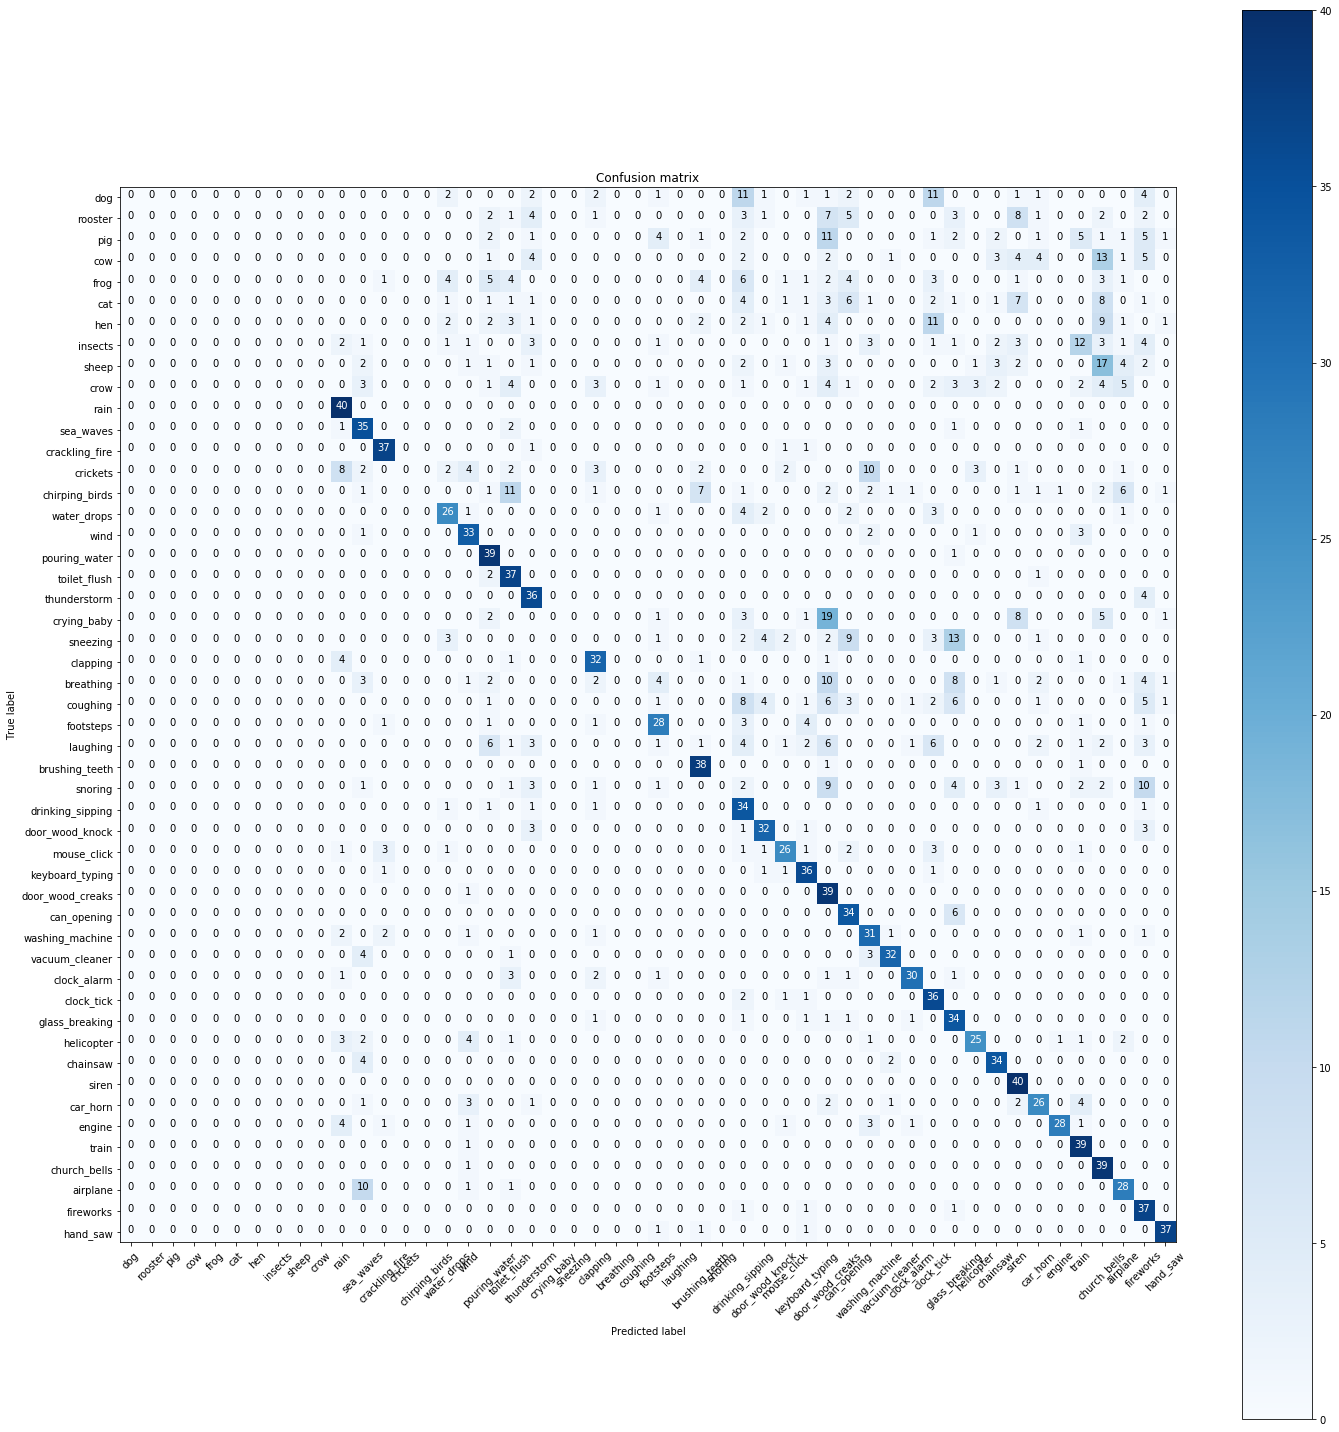

In [35]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [17]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []

    test = df[df.fold == 1]

    for data_iloc in range(0,len(test)):
        s_time = time.time()
        x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

        y_file = test.iloc[data_iloc].target
        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    return predictions

In [25]:
%%time
preds = query_dataset('dog')

CPU times: user 25.1 s, sys: 4.97 s, total: 30.1 s
Wall time: 17.1 s


In [26]:
preds.head()

,ds_id,file,prediction,prob
0,0,1-100032-A-0.wav,"[22, 22, 45, 22, 22, 22, 18, 22, 45, 45, 45, 1...",0.0
1,263,1-53444-A-28.wav,"[45, 41, 11, 11, 11, 11, 47, 11, 45, 11, 11, 1...",0.0
2,273,1-54752-A-18.wav,"[19, 19, 34, 19, 39, 43, 43, 33, 19, 12]",0.0
3,272,1-54747-A-46.wav,"[43, 19, 19, 43, 43, 43, 43, 43, 43, 41, 43, 4...",0.0
4,271,1-54505-A-21.wav,"[33, 40, 19, 29, 19, 19, 19, 48, 47, 29, 48, 3...",0.0


In [27]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [28]:
# Checking index
check_accuracy(preds, 'dog', 10)

dog
['snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']



0.1

In [30]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)

dog
['snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

0.1
rooster
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

0.0
pig
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

0.0
cow
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

0.0
frog
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

0.0
cat
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

0.0
hen
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

0.0
insects
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush',

0.022000000000000002